# Le problème : la prévision de consommation électrique

Pour garantir l'équilibre offre-demande à chaque instant et gérer l'acheminement de l'électricité, RTE construit ses propres prévisions de la consommation nationale, régionale, et locale, à différentes échéances de temps (de l'infrajournalier au pluri-annuel).

Ici on se focalise sur un problème particulier : **la prévision de la consommation électrique nationale horaire à horizon J+1** (on suppose qu'on connaît toutes les données jusqu'au jour J inclus). 

## Les données : Eco2mix

La courbe de charge France est disponible sur eco2mix :
http://www.rte-france.com/fr/eco2mix/eco2mix
ou sur application mobile.

Vous pouvez naviguer sur le site pour vous familiariser avec les données sur lesquelles vous aller travailler.

## Objectif :

Au cours de ce TP, nous allons aborder les différentes étapes nécessaires à la construction d'un modèle de prévision de consommation :

1) Formalisation du problème: que souhaite-t-on prédire (quel est mon Y) ? Avec quelles variables explicatives (quel est mon X) ?

2) Collecte des données: où se trouvent les données ? Quel est le format ? Comment les récupérer ? (FACULTATIF - voir TP "TP1_Preparation_donnees")

3) Import des données et analyses descriptives : visualiser des séries temporelles, statistiques descriptives

4) Transformation des données (feature engineering) pour entrainer et tester un premier modèle

5) Création de prévision à dire d'expert pour servir de référence.

6) Découpage des données : apprentissage - test

7) Evaluer un modèle

8) Tester des algorithmes de référence : régression linéaire, forêts aléatoires, xgboost

9) Itérer à partir des modèles testés pour améliorer les prévisions

Nous verrons qu'une difficulté majeure réside dans la construction des "bonnes" variables explicatives ("garbage in, garbage out")

## Méthodes de prévision considérées

Les modèles actuels reposent sur des méthodes de régression linéaire et non-linéaires. Nous étudierons ici les limites de la régression linéaire.

Pour améliorer les prévisions, nous aurons recours aux méthodes dites de Machine Learning. Ces méthodes ne dépendent pas d'une formalisation a priori du lien entre les variables explicatives X et la variable à expliquer Y. 
Elles sont souvent moins interprétables mais peuvent être plus efficaces en prévision. Elles peuvent nécessiter plus de temps de calcul et plus de données pour cela.

Construire un bon modèle d'apprentissage nécessite en général de la connaissance experte dans le domaine d'intérêt pour créer des modèles pertinents et efficaces. 

## To be continued : deep learning

Le deuxième TP permettra d'investiguer les modèles "Deep" avec réseaux de neurones, en montrant le moindre besoin en feature engineering et leur plus grande capacité à absorber l'information grâce aux représentations hiérarchiques qu'ils créent.

# On passe au code : import de librairies et configuration

** L'aide de python est accessible en tapant help(nom_de_la_commande) **

## Chargement des Librairies

In [1]:
# Exécutez la cellule ci-dessous (par exemple avec shift-entrée)
# Si vous exécuter ce notebook depuis votre PC, il faudra peut-etre installer certaines librairies avec 
# 'pip install ma_librairie'
import os  # accès aux commandes système
import datetime  # structure de données pour gérer des objets calendaires
import pytz # gestion des fuseaux horaires
import pandas as pd  # gérer des tables de données en python
import numpy as np  # librairie d'opérations mathématiques
import matplotlib.pyplot as plt  # tracer des visualisations
import sklearn  # librairie de machine learning
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor
from math import sqrt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

import shutil  # move ou copier fichier
import zipfile  # compresser ou décompresser fichier
import urllib3 # téléchargement de fichier

from collections import OrderedDict

import seaborn as sns

%matplotlib inline

%autosave 0

Autosave disabled


## Configuration
Choix du répertoire de travail "data_folder" dans lequel tous les fichiers csv seront entreposés

In [2]:
data_folder = os.path.join(os.getcwd(), "data")

In [3]:
# Petite vérification
print("Mon repertoire est : {}".format(data_folder))
print("Fichiers contenus dans ce répertoire :")
for file in os.listdir(data_folder):
    print(" - " + file)

Mon repertoire est : D:\Users\montuelleluc\Documents\Etudes\Formations-RTE\MOOC IA&DeepLearning\TP_Formation_Conso_DeepLearning\data
Fichiers contenus dans ce répertoire :
 - communes_coordonnees.csv
 - eCO2mix_RTE_tempo_2017-2018.xls
 - joursFeries.csv
 - meteoX_T0_T24.zip
 - StationsMeteoRTE.csv
 - Xinput.csv
 - Xinput.zip
 - Xtemperature.csv
 - Yconso.csv
 - YconsoT0.csv
 - Yconso_2014_2018.csv


# Récupération des données

Dans cette partie nous allons charger les fichiers csv nécessaires pour l'analyse, puis les convertir en data-frame python.
Les données brutes ont été pré-traitées à l'aide du notebook TP1_Preparation_donnees :
- Yconso.csv
- Xinput.csv

In [4]:
Yconso_csv = os.path.join(data_folder, "Yconso.csv")
Yconso = pd.read_csv(Yconso_csv)

La colonne "ds" contient des objets de type string. On va la convertir en objets de type "datetime" plus approprié.  
Pour plus d'information, voir le TP1_Preparation_donnees.

In [5]:
from datetime import timezone
Yconso['ds'] = pd.to_datetime(Yconso['ds'],utc=True)


In [6]:
print(Yconso.head(5))
print(Yconso.shape)

                         ds      y
0 2014-01-08 00:00:00+00:00  62008
1 2014-01-08 01:00:00+00:00  57298
2 2014-01-08 02:00:00+00:00  56216
3 2014-01-08 03:00:00+00:00  53719
4 2014-01-08 04:00:00+00:00  51798
(43368, 2)


**Attention : Les données Xinput sont encryptées dans un fichier zip. du fait de données météo**  
Pour les lire vous avez besoin d'un mot de passe qui ne peut vous être donné que dans le cadre d'un travail au sein de RTE.

In [7]:
Xinput_zip = os.path.join(data_folder, "Xinput.zip")

In [8]:
password = 'FIFA2019'

In [9]:
# Pour travailler avec les fichiers zip, on utilise la bibliothèque **zipfile**.
zipfile_xinput = zipfile.ZipFile(Xinput_zip)
zipfile_xinput.setpassword(bytes(password,'utf-8'))
Xinput = pd.read_csv(zipfile_xinput.open('Xinput.csv'),sep=",",engine='c',header=0)

Xinput['ds'] = pd.to_datetime(Xinput['ds'],utc=True)

Vous disposez de relevés de températures en stations, d'une température France prévue et réalisée.

In [10]:
print(Xinput.head(35))
print(Xinput.shape)
print(Xinput.columns)

                          ds holiday  002_0  002_24  005_0  005_24  015_0  \
0  2014-01-08 00:00:00+00:00     NaN  10.30    9.69  10.00    9.80   9.69   
1  2014-01-08 01:00:00+00:00     NaN  10.10    9.40   9.69    9.80   9.40   
2  2014-01-08 02:00:00+00:00     NaN  10.00    9.19   9.90    9.60   9.19   
3  2014-01-08 03:00:00+00:00     NaN   9.90    9.00   9.50    9.19   9.19   
4  2014-01-08 04:00:00+00:00     NaN   9.90    8.80   9.00    8.90   8.90   
5  2014-01-08 05:00:00+00:00     NaN   9.69    9.40   9.40    9.10   9.30   
6  2014-01-08 06:00:00+00:00     NaN   9.60    9.19   9.60    8.90   9.19   
7  2014-01-08 07:00:00+00:00     NaN   9.60    9.50   9.50    8.60   9.19   
8  2014-01-08 08:00:00+00:00     NaN   9.90    9.40   9.19    8.60   9.30   
9  2014-01-08 09:00:00+00:00     NaN  10.00    9.40  10.00    9.10   9.69   
10 2014-01-08 10:00:00+00:00     NaN  10.40    9.00  10.00    9.69  10.30   
11 2014-01-08 11:00:00+00:00     NaN  10.50    9.40  11.80   10.60  10.70   

Dans un premier temps, nous allons travailler **uniquement avec la température France.** Les températures en stations pourront être utilisées dans la partie Bonus, par exemple.

In [11]:
Xinput = Xinput[['ds', 'holiday', 'Th_real_24h_avant', 'Th_prev']]

* Quelles sont les variables disponibles (dans Xinput et Yconso)?
* Quelles sont les dimensions (nombre d’observations et de variables) de Xinput et Yconso après lecture des fichiers csv?

# Visualisation des données 

La DataScience et le Machine Learning supposent de bien appréhender les données sur lesquelles nos modèles vont être entrainés. Pour cela, il est utile de faire des statistiques descriptives et des visualisations de nos différentes variables.

Traitant d'un problème de prévision, on visualisera en particulier des séries temporelles.

Vous allez voir des :
- échantillons de données
- profils de courbe de consommation journaliers et saisonniers
- visualisations de corrélation entre conso J et conso retardée
- visualisations des séries temporelles des températures
- calculs de corrélations entre la température et les différentes stations météo

## Calcul de statistiques descriptives sur la consommation nationale
A l'aide de la fonction _describe_.

In [12]:
Yconso['y'].describe()

count    43368.000000
mean     54010.378574
std      11837.807039
min      29477.000000
25%      45025.250000
50%      52422.000000
75%      62167.000000
max      95987.000000
Name: y, dtype: float64

In [13]:
Yconso['y'].isnull().sum()

0

* Quelle est la valeur moyenne de la consommation horaire? son min et son max? 
* Quelle est la période temporelle étudiée?

## Visualiser la consommation d'un jour particulier
On souhaite visualiser la consommation réalisée pour un jour donné de l'historique.

In [14]:
def plot_load(var_load, year, month, day):
    date_cible = pytz.utc.localize(datetime.datetime(year=year, month=month, day=day))  # implicitement heure = minuit
    date_lendemain_cible = date_cible + datetime.timedelta(days=1)
    mask = (var_load.ds >= date_cible) & (var_load.ds <= date_lendemain_cible)   
    consoJour = var_load[mask]
    plt.plot(consoJour['ds'], consoJour['y'], color='blue')
    plt.show()

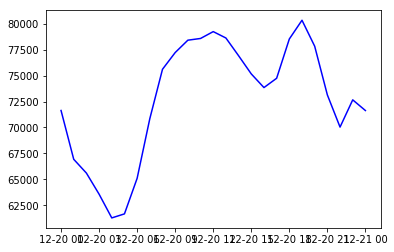

In [15]:
plot_load(Yconso, 2016, 12, 20)

* Afficher un jour ouvré d’hiver, un jour ouvré d’été, commenter.

## Afficher une semaine arbitraire de consommation
On pourra modifier la fonction précédente en rajoutant le timedelta en paramètre.

In [16]:
def plot_load_timedelta(var_load, year, month, day, delta_days):
    date_cible = pytz.utc.localize(datetime.datetime(year=year, month=month, day=day))
    date_lendemain_cible = date_cible + datetime.timedelta(days=delta_days)

    conso_periode = var_load[(var_load.ds >= date_cible) 
                                      & (var_load.ds <= date_lendemain_cible)]
    plt.plot(conso_periode['ds'], conso_periode['y'], color='blue')
    plt.show()

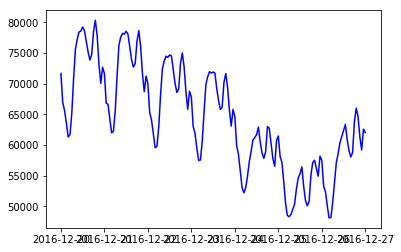

In [17]:
plot_load_timedelta(Yconso, 2016, 12, 20, delta_days=7)

* Commenter.

## Observation des profils de la consommation pour les mois d'hiver et les mois d'été
Toujours dans le but d'appréhender nos données, on va regarder les profils moyens pour les mois d'été et pour ceux d'hiver. On va également observer le min et le max pour avoir une idée de la variabilité du signal.

In [18]:
# Par commodité, on isole le mois pour après attraper les mois d'hiver et d'été
Xinput['month'] = Xinput['ds'].dt.month

# On isole aussi les heures
Xinput['hour'] = Xinput['ds'].dt.hour

# On sépare les jours de la semaine en week-end / pas week-end
# De base, la fonction datetime.weekday() renvoie 0 => Lundi, 2 => Mardi, ..., 5 => Samedi, 6 => Dimanche
# Ci-dessous, si on a un jour d ela semaine alors dans la colonne weekday on mettra 1, et 0 si c'est le week-end
Xinput['weekday'] = (Xinput['ds'].dt.weekday < 5).astype(int)  # conversion bool => int

In [19]:
Xinput.head(5)

,ds,holiday,Th_real_24h_avant,Th_prev,month,hour,weekday
0,2014-01-08 00:00:00+00:00,NaN,9.84693,9.911160,1,0,1
1,2014-01-08 01:00:00+00:00,NaN,9.84850,9.790830,1,1,1
2,2014-01-08 02:00:00+00:00,NaN,9.68158,9.634990,1,2,1
3,2014-01-08 03:00:00+00:00,NaN,9.48713,9.445360,1,3,1
4,2014-01-08 04:00:00+00:00,NaN,9.49041,9.241585,1,4,1


In [20]:
# On aggrège les mois d'hiver ensemble
XY_df = pd.merge(Yconso, Xinput, on = 'ds')
groupedHiver = XY_df[(XY_df.month == 12) | 
                                     (XY_df.month == 1) | 
                                     (XY_df.month == 2)].groupby(['weekday', 'hour'], as_index=True)

# Idem pour les mois d'été
groupedEte = XY_df[(XY_df.month == 6) | 
                                   (XY_df.month == 7) | 
                                   (XY_df.month == 8)].groupby(['weekday', 'hour'], as_index=True)

statsHiver = groupedHiver['y'].aggregate([np.mean, np.min, np.max])
statsEte = groupedEte['y'].aggregate([np.mean, np.min, np.max])

In [21]:
print(statsHiver)

                      mean   amin   amax
weekday hour                            
0       0     67832.325203  52914  84120
        1     63309.195122  48866  79849
        2     62097.211382  47963  79895
        3     59472.528455  45759  77368
        4     56962.000000  43833  74752
        5     56103.804878  43520  74342
        6     57101.853659  44858  75698
        7     58858.471545  46444  77952
        8     60808.138211  48324  81395
        9     62916.967480  49467  83783
        10    65223.593496  51791  85464
        11    65961.528455  52786  84509
        12    66746.105691  53317  83314
        13    67739.390244  54316  83593
        14    64093.276423  50394  79803
        15    61543.170732  47892  76792
        16    60136.536585  46704  75135
        17    60363.040650  47935  75184
        18    64507.235772  50872  80259
        19    68899.365854  57070  82733
        20    68199.227642  56500  81352
        21    65444.634146  54213  78545
        22    63

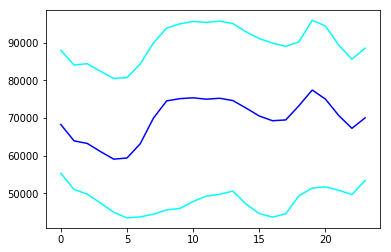

In [22]:
# On affiche des infos sur le profil pour les jours de la semaine
semaine = statsHiver.loc[1]  # 0 pour les jours de semaine
weekend = statsHiver.loc[0]  # 0 pour weekend

plt.plot(semaine['amin'], color='cyan')
plt.plot(semaine['mean'], color='blue')
plt.plot(semaine['amax'], color='cyan')
plt.show()

## Lien avec la consommation passée
A l'aide de la fonction shift, pour un point horaire cible on regarde  :
- la consommation de l'heure précédente, 
- du jour précédent, 
- de la semaine précédente.

On regarde ensuite si la consommation réalisée peut se deviner à partir de ces observations.

In [23]:
Xinput['lag1H'] = Yconso['y'].shift(1)
Xinput['lag1D'] = Yconso['y'].shift(24)
Xinput['lag1W'] = Yconso['y'].shift(24*7)

In [24]:
Xinput.head(24 * 7 + 1)

,ds,holiday,Th_real_24h_avant,Th_prev,month,hour,weekday,lag1H,lag1D,lag1W
0,2014-01-08 00:00:00+00:00,NaN,9.846930,9.911160,1,0,1,NaN,NaN,NaN
1,2014-01-08 01:00:00+00:00,NaN,9.848500,9.790830,1,1,1,62008.0,NaN,NaN
2,2014-01-08 02:00:00+00:00,NaN,9.681580,9.634990,1,2,1,57298.0,NaN,NaN
3,2014-01-08 03:00:00+00:00,NaN,9.487130,9.445360,1,3,1,56216.0,NaN,NaN
4,2014-01-08 04:00:00+00:00,NaN,9.490410,9.241585,1,4,1,53719.0,NaN,NaN
5,2014-01-08 05:00:00+00:00,NaN,9.346880,9.045105,1,5,1,51798.0,NaN,NaN
6,2014-01-08 06:00:00+00:00,NaN,9.284855,8.915265,1,6,1,52083.0,NaN,NaN
7,2014-01-08 07:00:00+00:00,NaN,9.377060,8.964100,1,7,1,56082.0,NaN,NaN
8,2014-01-08 08:00:00+00:00,NaN,9.543030,9.106500,1,8,1,63083.0,NaN,NaN
9,2014-01-08 09:00:00+00:00,NaN,10.109460,9.630050,1,9,1,68358.0,NaN,NaN


On regarde maintenant graphiquement si on a une belle corrélation ou non :

In [25]:
def plot_scatter_load(var_x):
    plt.scatter(Xinput[var_x],Yconso['y'])
    plt.title(var_x)
    plt.show()

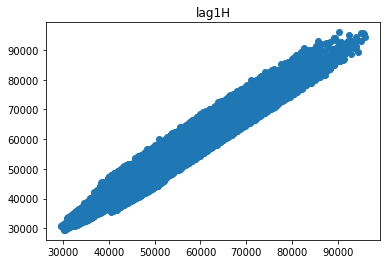

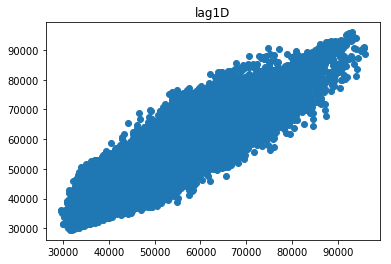

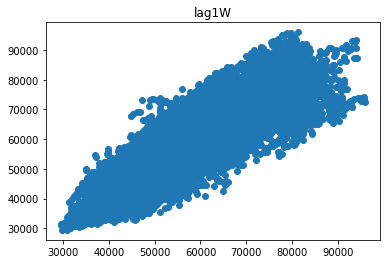

In [26]:
plot_scatter_load('lag1H')
plot_scatter_load('lag1D')
plot_scatter_load('lag1W')

* Qu'en pensez-vous?

## Visualiser la consommation en fonction de la température 
On voudrait savoir si la consommation nationale peut s'expliquer en regardant simplement la température moyenne sur la France. Pour cela, on peut tracer un nuage de points.

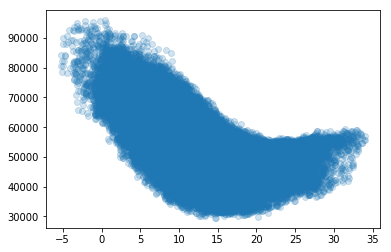

In [27]:
plt.scatter(Xinput['Th_prev'], Yconso['y'], alpha=0.2)
plt.show()

### Question
Que pensez-vous de ce nuage ? Est-ce suffisant ?

# Bricolage d'un modèle prédictif naïf

<img src="pictures/hommeNaif.png" width=500 height=60>

In [28]:
# Pour se faire les dents on va considérer juste un point horaire
datetime_a_predire = pytz.utc.localize(datetime.datetime.strptime("2016-12-20_14:00", "%Y-%m-%d_%H:%M"))
y_true_point_horaire_cible = float(Yconso.loc[Yconso['ds'] == datetime_a_predire]['y'])

print("On veut predire la consommation du {}, soit {}".format(datetime_a_predire, y_true_point_horaire_cible))

On veut predire la consommation du 2016-12-20 14:00:00+00:00, soit 76906.0


## Première idée, un modèle naïf : pour l'heure qui nous intéresse, on plaque bêtement la valeur de consommation nationale de la veille

On commence par juste notre point horaire

In [29]:
y_pred_modele_naif_1 = float(Xinput.loc[Xinput['ds'] == datetime_a_predire]['lag1D'])
pred_error = abs(y_true_point_horaire_cible - y_pred_modele_naif_1)

print("Modele 1 -- pred: {}, realisee: {}, erreur: {}%".format(y_pred_modele_naif_1, y_true_point_horaire_cible, pred_error/y_true_point_horaire_cible * 100))

Modele 1 -- pred: 78273.0, realisee: 76906.0, erreur: 1.777494603802044%


Voyons maintenant ce que ça donne non plus sur un unique point horaire mais sur l'ensemble des points horaires :

In [30]:
y_pred_modele_naif_1 = Xinput["lag1D"]

pred_error = (np.abs(Yconso["y"] - y_pred_modele_naif_1.loc[24:]) / Yconso["y"] * 100)

print(np.mean(pred_error))

5.817903709655765


Bon c'est pas fou...

## Deuxième idée : modèle naïf avec de l'expertise métier 

Chez RTE, on considère qu'une augmentation moyenne de 1°C conduit à une augmentation de 2400MW de la consommation nationale pour des températures inférieures à 15°C. On propose donc comme consommation prévue la consommation de la veille, corrigée par 2400 fois l'écart à la température de la veille, si l'on n'excède pas les 15°C.


<img src="pictures/ExpertJamy.jpg" width=500 height=60>

In [31]:
delta_MW_par_degre = 2400  
            
threshold_temperature = 15

On commence par juste notre point horaire préféré

In [32]:
temperature_real_veille = float(Xinput.loc[Xinput['ds'] == datetime_a_predire]['Th_real_24h_avant'])
temperature_prevu_cible = float(Xinput.loc[Xinput['ds'] == datetime_a_predire]['Th_prev'])
delta_temp = min(threshold_temperature, temperature_prevu_cible) - min(threshold_temperature, temperature_real_veille)
delta_MW_because_temp = delta_temp * delta_MW_par_degre

y_pred_modele_naif_2 = float(Xinput.loc[Xinput['ds'] == datetime_a_predire]['lag1D']) - delta_MW_because_temp
pred_error = abs(y_true_point_horaire_cible - y_pred_modele_naif_2)

print("Modele 2 -- pred: {}, realisee: {}, erreur: {}%".format(y_pred_modele_naif_2, y_true_point_horaire_cible, pred_error/y_true_point_horaire_cible * 100))

Modele 2 -- pred: 78099.444, realisee: 76906.0, erreur: 1.551821704418385%


Et maintenant sur l'ensemble des points horaires :

In [33]:
y_pred = Xinput["lag1D"]

temp_prev_with_threshold = np.minimum([threshold_temperature], Xinput['Th_prev'].values)
temp_actual_with_threshold = np.minimum([threshold_temperature], Xinput['Th_real_24h_avant'].values)

delta_temp = temp_prev_with_threshold - temp_actual_with_threshold
delta_MW_because_temp = delta_temp * delta_MW_par_degre

y_pred_modele_naif_2 = Xinput["lag1D"] - delta_MW_because_temp
pred_error = (np.abs(Yconso["y"] - y_pred_modele_naif_2) / Yconso["y"] * 100)

print(np.mean(pred_error))

6.818406826437223


Bon... Bien essayé avec ces modèles naïfs, mais maintenant on va être plus sérieux !

# Préparer un jeu d'entrainement et un jeu de test
En machine learning, il y a 2 types d'erreur que l'on peut calculer : l'erreur d'entrainement et l'erreur de test. 

Pour évaluer la capacité de notre modèle à bien généraliser sur de nouvelles données, il est très important de se préserver un jeu de test indépendant de celui d'entrainement.

Il faut donc segmenter notre dataset en 2 : 
- un premier jeu servira pour l'entrainement, 
- tandis que le second servira à mesurer les performances du modèle prédictif.

In [34]:
def prepareDataSetEntrainementTest(Xinput, Yconso, dateDebut, dateRupture, nbJourlagRegresseur=0):
    
    dateStart = Xinput.iloc[0]['ds']
    
    DateStartWithLag = dateStart + pd.Timedelta(str(nbJourlagRegresseur)+' days')  #si un a un regresseur avec du lag, il faut prendre en compte ce lag et commencer l'entrainement a la date de debut des donnees+ce lag
    XinputTest = Xinput[(Xinput.ds >= dateRupture)]    

    XinputTrain=Xinput[(Xinput.ds < dateRupture) & (Xinput.ds > DateStartWithLag) & (Xinput.ds > dateDebut)]
    YconsoTrain=Yconso[(Yconso.ds < dateRupture) & (Yconso.ds > DateStartWithLag) & (Yconso.ds > dateDebut)]
    YconsoTest=Yconso[(Xinput.ds >= dateRupture)]
    
    return XinputTrain, XinputTest, YconsoTrain, YconsoTest

# Fonctions utilitaires

Créons la fonction modelError qui va calculer pour un échantillon (Y, Y_hat) différents scores :
- erreur relative moyenne (MAPE en %)
- erreur relative max (en %)
- rmse (en MW)


In [35]:
def modelError(Y, Yhat):

    Y = Y.reset_index(drop=True)
    
    relativeErrorsTest = np.abs((Y['y'] - Yhat) /Y['y']) 
    errorMean = np.mean(relativeErrorsTest)
    errorMax = np.max(relativeErrorsTest)
    rmse = np.sqrt(mean_squared_error(Y['y'], Yhat))
   
    return relativeErrorsTest, errorMean, errorMax, rmse

In [36]:
def evaluation(YTrain, YTest, YTrainHat, YTestHat):
    # Ytrain et Ytest ont deux colonnes : ds et y
    # YtrainHat et YTestHat sont des vecteurs
    ErreursTest, ErreurMoyenneTest, ErreurMaxTest, RMSETest = modelError(YTest, YTestHat)
    print("l'erreur relative moyenne de test est de:" + str(round(ErreurMoyenneTest*100,1))+"%")
    print("l'erreur relative max de test est de:" + str(round(ErreurMaxTest*100,1)) +"%")
    print('le rmse de test est de:' + str(round(RMSETest,0)))
    print()
    ErreursTest, ErreurMoyenneTest, ErreurMaxTest, RMSETest = modelError(YTrain, YTrainHat)
    print("l'erreur relative moyenne de train est de:" + str(round(ErreurMoyenneTest*100,1))+"%")
    print("l'erreur relative max de train est de:" + str(round(ErreurMaxTest*100,1)) +"%")
    print('le rmse de test est de:' + str(round(RMSETest,0))) 

In [37]:
def evaluation_par(X, Y, Yhat,avecJF=True):
    Y['weekday'] = Y['ds'].dt.weekday
    Y['hour'] = Y['ds'].dt.hour
    if(avecJF):
        Y['JoursFeries'] = X['JoursFeries']
    Y['APE'] = np.abs(Y['y']-Yhat)/Y['y']
    dataWD = Y[['weekday','APE']]
    groupedWD = dataWD.groupby(['weekday'], as_index=True)
    statsWD = groupedWD.aggregate([np.mean])
    dataHour = Y[['hour','APE']]
    groupedHour = dataHour.groupby(['hour'], as_index=True)
    statsHour = groupedHour.aggregate([np.mean])
    
    if(avecJF):
        dataJF = Y[['JoursFeries','APE']]
        groupedJF = dataJF.groupby(['JoursFeries'], as_index=True)
        statsJF = groupedJF.aggregate([np.mean])
    else:
        statsJF = None
    
    return statsWD, statsHour, statsJF

## Preparation de Xinput

In [38]:
Xinput = Xinput.drop(['lag1H'],axis=1)  # on supprime la consommation retardée d'une heure, non disponible pour notre exercice de prévision

In [39]:
print(Xinput.shape)
print(Xinput.columns)

(43368, 9)
Index(['ds', 'holiday', 'Th_real_24h_avant', 'Th_prev', 'month', 'hour',
       'weekday', 'lag1D', 'lag1W'],
      dtype='object')


On encode les données calendaires en one-hot encoding pour le modèle.
Cet encodage est nécessaire pour que le modèle mathématique puisse appréhender la notion de date.

In [40]:
encodedWeekDay = pd.get_dummies(Xinput['weekday'],prefix="weekday")
encodedMonth = pd.get_dummies(Xinput['month'],prefix="month")
encodedHour = pd.get_dummies(Xinput['hour'],prefix="hour")

In [41]:
encodedWeekDay.head(3)

,weekday_0,weekday_1
0,0,1
1,0,1
2,0,1


In [42]:
encodedMonth.head(3)

,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
0,1,0,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,0,0


In [43]:
encodedHour.head(3)

,hour_0,hour_1,hour_2,hour_3,hour_4,hour_5,hour_6,hour_7,hour_8,hour_9,...,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [44]:
Xinput = pd.concat([Xinput, encodedMonth, encodedWeekDay, encodedHour], axis=1)
Xinput = Xinput.drop(['month','weekday','hour'],axis=1)

In [45]:
print(Xinput.shape)
print(Xinput.columns)

(43368, 44)
Index(['ds', 'holiday', 'Th_real_24h_avant', 'Th_prev', 'lag1D', 'lag1W',
       'month_1', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6',
       'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12',
       'weekday_0', 'weekday_1', 'hour_0', 'hour_1', 'hour_2', 'hour_3',
       'hour_4', 'hour_5', 'hour_6', 'hour_7', 'hour_8', 'hour_9', 'hour_10',
       'hour_11', 'hour_12', 'hour_13', 'hour_14', 'hour_15', 'hour_16',
       'hour_17', 'hour_18', 'hour_19', 'hour_20', 'hour_21', 'hour_22',
       'hour_23'],
      dtype='object')


In [46]:
# Récupération des prévisions météo à J+1 pour la veille
colsToKeepWeather = [s for s in Xinput.columns.get_values() if 'Th_prev' in s]
lag_colsToKeepWeather = [ s + "_J_1" for s in colsToKeepWeather ]
Xinput[lag_colsToKeepWeather] = Xinput[colsToKeepWeather].shift(24)
time = pd.to_datetime(Xinput['ds'], yearfirst=True,utc=True)
Xinput['posan']= time.dt.dayofyear

In [47]:
#Récupération des jours fériés dans Xinput
encodedHolidays = pd.get_dummies(Xinput[['holiday']], prefix = "JF")
encodedHolidays['JoursFeries'] = encodedHolidays.sum(axis = 1)
Xinput = pd.concat([Xinput, encodedHolidays], axis = 1)
Xinput = Xinput.drop(['holiday'], axis = 1)

On ajoute des températures seuillées, à 15°C pour l'effet chauffage, et à 18°C pour l'effet climatisation.

In [48]:
threshold_temperature_heat = 15
threshold_temperature_cool = 18

Xinput['temp_prev_with_threshold_heat'] = np.maximum(0, threshold_temperature_heat - Xinput['Th_prev'].values)
Xinput['temp_prev_with_threshold_cool'] = np.maximum(0, Xinput['Th_prev'].values - threshold_temperature_cool)

In [49]:
#affichage de toutes les variables de base
list(Xinput) #list plutôt que print pour avoir la liste complète

['ds',
 'Th_real_24h_avant',
 'Th_prev',
 'lag1D',
 'lag1W',
 'month_1',
 'month_2',
 'month_3',
 'month_4',
 'month_5',
 'month_6',
 'month_7',
 'month_8',
 'month_9',
 'month_10',
 'month_11',
 'month_12',
 'weekday_0',
 'weekday_1',
 'hour_0',
 'hour_1',
 'hour_2',
 'hour_3',
 'hour_4',
 'hour_5',
 'hour_6',
 'hour_7',
 'hour_8',
 'hour_9',
 'hour_10',
 'hour_11',
 'hour_12',
 'hour_13',
 'hour_14',
 'hour_15',
 'hour_16',
 'hour_17',
 'hour_18',
 'hour_19',
 'hour_20',
 'hour_21',
 'hour_22',
 'hour_23',
 'Th_prev_J_1',
 'posan',
 'JF_11Novembre',
 'JF_1erMai',
 'JF_8Mai',
 'JF_Ascension',
 'JF_Assomption',
 'JF_FeteNationale',
 'JF_Noel',
 'JF_NouvelAn',
 'JF_Paques',
 'JF_Pentecote',
 'JF_Toussaint',
 'JoursFeries',
 'temp_prev_with_threshold_heat',
 'temp_prev_with_threshold_cool']

Enfin, nous construisons les listes pour appeler plus rapidement les colonnes d'un même type.

In [50]:
colsToKeepWeather = [s for s in Xinput.columns.get_values() if 'Th_prev' in s]
colsToKeepMonth = [v for v in Xinput.columns.get_values() if 'month' in v]
colsToKeepWeekday = [v for v in Xinput.columns.get_values() if 'weekday' in v]
colsToKeepHour = [v for v in Xinput.columns.get_values() if 'hour' in v]
colsToKeepHolidays = [v for v in Xinput.columns.get_values() if 'JF_' in v]

# Construction des jeux d'entrainement et de test

In [51]:
# on souhaite un jeu de test qui commence à partir du 1er mai 2017
dateDebut = pytz.utc.localize( datetime.datetime(year=2014, month=1, day=15))#pour éviter les NaN dans le jeu de données
dateRupture = pytz.utc.localize(datetime.datetime(year=2017, month=12, day=1))#début du challenge prevision de conso
nbJourlagRegresseur = 0

In [52]:
Yconso.tail()

,ds,y
43363,2018-12-19 19:00:00+00:00,75670
43364,2018-12-19 20:00:00+00:00,73068
43365,2018-12-19 21:00:00+00:00,68589
43366,2018-12-19 22:00:00+00:00,65288
43367,2018-12-19 23:00:00+00:00,67766


In [53]:
XinputTrain, XinputTest, YconsoTrain, YconsoTest = prepareDataSetEntrainementTest(Xinput, Yconso, 
                                                                                  dateDebut, dateRupture, 
                                                                                  nbJourlagRegresseur)

In [54]:
print('la taille de l échantillon XinputTrain est:' + str(XinputTrain.shape))
print('la taille de l échantillon XinputTest est:' + str(XinputTest.shape))
print('la taille de l échantillon YconsoTrain est:' + str(YconsoTrain.shape))
print('la taille de l échantillon YconsoTest est:' + str(YconsoTest.shape))
print("la proportion de data d'entrainement est de:" + str(YconsoTrain.shape[0] / (YconsoTrain.shape[0] + YconsoTest.shape[0])))

la taille de l échantillon XinputTrain est:(33983, 59)
la taille de l échantillon XinputTest est:(9216, 59)
la taille de l échantillon YconsoTrain est:(33983, 2)
la taille de l échantillon YconsoTest est:(9216, 2)
la proportion de data d'entrainement est de:0.7866617282807472


## Test des fonctions sur le modèle expert

Recalculons les prévisions à l'aide des deux modèles experts et évaluons ces deux approches :

### Modèle naïf 1

In [55]:
pred_train_naif1= XinputTrain["lag1D"]
pred_test_naif1= XinputTest["lag1D"]
evaluation(YconsoTrain, YconsoTest,  pred_train_naif1.values,pred_test_naif1.values)


l'erreur relative moyenne de test est de:5.7%
l'erreur relative max de test est de:37.8%
le rmse de test est de:4528.0

l'erreur relative moyenne de train est de:5.8%
l'erreur relative max de train est de:41.0%
le rmse de test est de:4590.0


### Modèle naïf 2

In [56]:
# prévision train
temp_prev_with_threshold = np.minimum([threshold_temperature], XinputTrain['Th_prev'].values)
temp_actual_with_threshold = np.minimum([threshold_temperature], XinputTrain['Th_real_24h_avant'].values)

delta_temp = temp_prev_with_threshold - temp_actual_with_threshold
delta_MW_because_temp = delta_temp * delta_MW_par_degre

pred_train_naif2 = XinputTrain["lag1D"] - delta_MW_because_temp


# prévision test
temp_prev_with_threshold = np.minimum([threshold_temperature], XinputTest['Th_prev'].values)
temp_actual_with_threshold = np.minimum([threshold_temperature], XinputTest['Th_real_24h_avant'].values)

delta_temp = temp_prev_with_threshold - temp_actual_with_threshold
delta_MW_because_temp = delta_temp * delta_MW_par_degre
pred_test_naif2 = XinputTest["lag1D"] - delta_MW_because_temp

# scores
evaluation(YconsoTrain, YconsoTest,  pred_train_naif2.values,pred_test_naif2.values)


l'erreur relative moyenne de test est de:6.7%
l'erreur relative max de test est de:40.1%
le rmse de test est de:5015.0

l'erreur relative moyenne de train est de:6.9%
l'erreur relative max de train est de:44.1%
le rmse de test est de:5045.0



# Régression linéaire simple

Le modèle naïf avec expertise métier a été inspiré de la forme de la courbe d'évolution de la consommation en fonction de la température en France. 
Pour rappel:

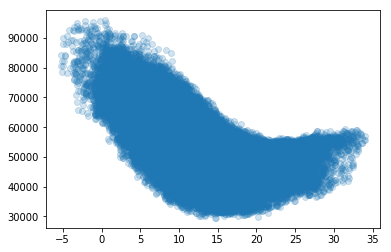

In [57]:
plt.scatter(Xinput['Th_prev'], Yconso['y'], alpha=0.2)
plt.show()

La consommation pourrait être modélisée par une fonction linéaire par morceaux de la température, avec une pente plus importante pour les températures froides que pour les températures élevées. Au lieu de fixer les gradients à 2400MW/°C et 0, ceux-ci pourraient être calibrés à partir des données.


## Entrainer un modèle
Notre modèle a des paramètres qu'il va falloir maintenant apprendre au vu de notre jeu d'entrainement. Il faut donc caler notre modèle sur ce jeu d'entrainement.

In [58]:
colsLR_simple = np.concatenate(([s for s in XinputTrain.columns.get_values() if 'temp_prev_with_' in s], colsToKeepHour, colsToKeepWeekday, colsToKeepMonth))

mTrain = linear_model.LinearRegression(fit_intercept = False)

In [59]:
mTrain.fit(XinputTrain[colsLR_simple], YconsoTrain[['y']])
coef_joli = pd.DataFrame(np.concatenate(( np.array([colsLR_simple]).T,mTrain.coef_.T),axis=1),columns = ['variable','coefficient'])
print(coef_joli)


                         variable          coefficient
0   temp_prev_with_threshold_heat   1417.5408370287034
1   temp_prev_with_threshold_cool   0.6471653906410211
2                          hour_0    3098.775040720738
3                          hour_1  -2066.9583380855724
4                          hour_2  -3511.4932768077015
5                          hour_3   -6077.362917274427
6                          hour_4   -8196.570957403468
7                          hour_5   -8260.652473239421
8                          hour_6   -5607.051928846613
9                          hour_7     -683.41801400479
10                         hour_8   3508.5496977590556
11                         hour_9    6335.179156112747
12                        hour_10    8421.447486944651
13                        hour_11    9506.724985011435
14                        hour_12   10731.706599402887
15                        hour_13   11246.316701793201
16                        hour_14    9246.352869510982
17        

* Commentez les coefficients de régression obtenus. 
* Comparez notamment les gradients obtenus avec le modèle naïf.

## Faire des prédictions
Une fois qu'un modèle de prévision est entrainé, il ne s'avère utile que s'il est performant sur de nouvelles situations. Faisons une prévision sur notre jeu de test.

In [60]:
forecastTest = np.concatenate(mTrain.predict(XinputTest[colsLR_simple]))
forecastTrain = np.concatenate(mTrain.predict(XinputTrain[colsLR_simple]))

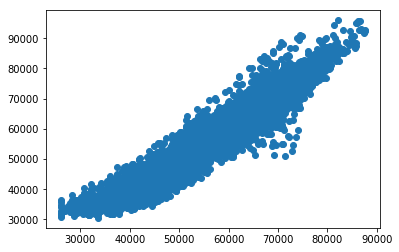

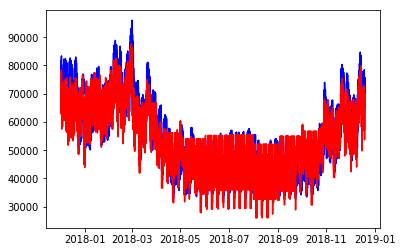

In [61]:
# on visualise nos previsions 

plt.scatter(forecastTest, YconsoTest[['y']])
plt.show()

plt.plot(YconsoTest['ds'], YconsoTest['y'], 'b', YconsoTest['ds'], forecastTest, 'r')
plt.show()

## Interpreter le modèle 
Au vu des visualisations précédentes :
- quelles interprétations pouvez-vous faire du modèle?
- Comment varie le comportement de la courbe de consommation?

## Evaluer l'erreur de prévision
Quelle est la performance de notre modèle sur ce jeu de test ?

In [62]:
evaluation(YconsoTrain, YconsoTest, forecastTrain,  forecastTest)

l'erreur relative moyenne de test est de:5.2%
l'erreur relative max de test est de:40.1%
le rmse de test est de:3675.0

l'erreur relative moyenne de train est de:5.1%
l'erreur relative max de train est de:52.7%
le rmse de test est de:3388.0


## Enquêter autour des erreurs de prévision

### Evaluation en fonction du jour de semaine, de l'heure, si jour férié ou non

### Comment se distribue l'erreur ?

In [63]:
erreur_relative_test, erreur_moyenne_test, erreur_max_test, rmse = modelError(YconsoTest, forecastTest)

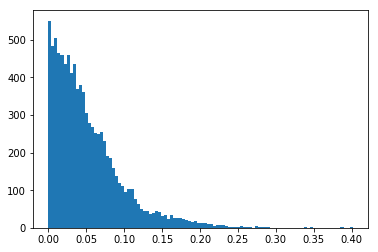

In [64]:
num_bins = 100
plt.hist(erreur_relative_test, num_bins)
plt.show()

### A quel moment se trompe-t-on le plus ?

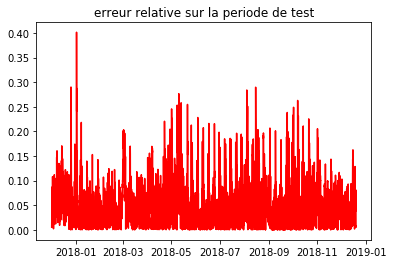

In [65]:
plt.plot(YconsoTest['ds'], erreur_relative_test, 'r')
plt.title("erreur relative sur la periode de test")
plt.show()

In [66]:
erreur_relative_test.head()

0    0.005789
1    0.008707
2    0.014343
3    0.021133
4    0.025835
Name: y, dtype: float64

In [67]:
threshold = 0.18

mask = (erreur_relative_test >= threshold)
erreurs_df = pd.DataFrame(np.concatenate((YconsoTest[['ds','y']],np.array([forecastTest]).T),axis=1),columns=["date","y","prev"])
print(erreurs_df[mask])


                           date      y     prev
583   2017-12-25 07:00:00+00:00  53135    64922
584   2017-12-25 08:00:00+00:00  54321  68854.2
585   2017-12-25 09:00:00+00:00  55134  71127.7
586   2017-12-25 10:00:00+00:00  57603  72090.5
587   2017-12-25 11:00:00+00:00  59479  71283.6
591   2017-12-25 15:00:00+00:00  55844    66877
592   2017-12-25 16:00:00+00:00  55056  65971.7
750   2018-01-01 06:00:00+00:00  50751  60475.6
751   2018-01-01 07:00:00+00:00  51180    65290
752   2018-01-01 08:00:00+00:00  51462  69241.4
753   2018-01-01 09:00:00+00:00  51035    71515
754   2018-01-01 10:00:00+00:00  52495  72823.8
755   2018-01-01 11:00:00+00:00  54658  73138.2
756   2018-01-01 12:00:00+00:00  57169  73718.8
757   2018-01-01 13:00:00+00:00  59666  74040.8
758   2018-01-01 14:00:00+00:00  57285  72211.9
759   2018-01-01 15:00:00+00:00  55044  70862.9
760   2018-01-01 16:00:00+00:00  54649  69633.1
761   2018-01-01 17:00:00+00:00  55705  68971.4
896   2018-01-07 08:00:00+00:00  53629  

## Feature engineering
Quelles variables explicatives peuvent nous permettre de créer un modele plus perfomant ?

# Autres modèles : RandomForest et XGBoost

## Modèle RandomForest

<img src="pictures/randomForestExplain.png" width=500 height=30>

### Préparation des données d'entrée

In [68]:

colsRF = np.concatenate((['lag1D','lag1W'],
                         colsToKeepWeather,colsToKeepMonth,colsToKeepWeekday,colsToKeepHour,colsToKeepHolidays))
list(colsRF)

['lag1D',
 'lag1W',
 'Th_prev',
 'Th_prev_J_1',
 'month_1',
 'month_2',
 'month_3',
 'month_4',
 'month_5',
 'month_6',
 'month_7',
 'month_8',
 'month_9',
 'month_10',
 'month_11',
 'month_12',
 'weekday_0',
 'weekday_1',
 'hour_0',
 'hour_1',
 'hour_2',
 'hour_3',
 'hour_4',
 'hour_5',
 'hour_6',
 'hour_7',
 'hour_8',
 'hour_9',
 'hour_10',
 'hour_11',
 'hour_12',
 'hour_13',
 'hour_14',
 'hour_15',
 'hour_16',
 'hour_17',
 'hour_18',
 'hour_19',
 'hour_20',
 'hour_21',
 'hour_22',
 'hour_23',
 'JF_11Novembre',
 'JF_1erMai',
 'JF_8Mai',
 'JF_Ascension',
 'JF_Assomption',
 'JF_FeteNationale',
 'JF_Noel',
 'JF_NouvelAn',
 'JF_Paques',
 'JF_Pentecote',
 'JF_Toussaint']

### Entrainement du modèle

In [69]:
# La cellule peut prendre un peu de temps à exécuter
print(Xinput.head(20))
rfTrain = RandomForestRegressor(n_estimators=30, max_features=colsRF.size, n_jobs=3, oob_score = True, bootstrap = True)
rfTrain.fit(XinputTrain[colsRF], YconsoTrain['y'])

                          ds  Th_real_24h_avant    Th_prev  lag1D  lag1W  \
0  2014-01-08 00:00:00+00:00           9.846930   9.911160    NaN    NaN   
1  2014-01-08 01:00:00+00:00           9.848500   9.790830    NaN    NaN   
2  2014-01-08 02:00:00+00:00           9.681580   9.634990    NaN    NaN   
3  2014-01-08 03:00:00+00:00           9.487130   9.445360    NaN    NaN   
4  2014-01-08 04:00:00+00:00           9.490410   9.241585    NaN    NaN   
5  2014-01-08 05:00:00+00:00           9.346880   9.045105    NaN    NaN   
6  2014-01-08 06:00:00+00:00           9.284855   8.915265    NaN    NaN   
7  2014-01-08 07:00:00+00:00           9.377060   8.964100    NaN    NaN   
8  2014-01-08 08:00:00+00:00           9.543030   9.106500    NaN    NaN   
9  2014-01-08 09:00:00+00:00          10.109460   9.630050    NaN    NaN   
10 2014-01-08 10:00:00+00:00          11.010330  10.447800    NaN    NaN   
11 2014-01-08 11:00:00+00:00          12.087900  11.583100    NaN    NaN   
12 2014-01-0

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=53, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=30, n_jobs=3, oob_score=True, random_state=None,
           verbose=0, warm_start=False)

### Prediction

In [70]:
forecastTest = rfTrain.predict(XinputTest[colsRF])
forecastTrain = rfTrain.predict(XinputTrain[colsRF])

### Evaluation

l'erreur relative moyenne de test est de:2.8%
l'erreur relative max de test est de:37.2%
le rmse de test est de:2507.0

l'erreur relative moyenne de train est de:0.9%
l'erreur relative max de train est de:14.5%
le rmse de test est de:726.0


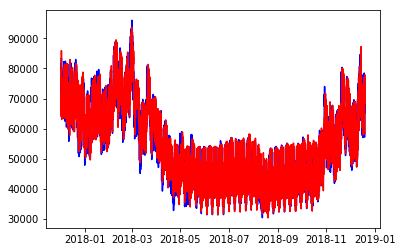

R^2 Training Score: 1.00 
OOB Score: 0.97 
R^2 Validation Score: 0.96


In [71]:
evaluation(YconsoTrain, YconsoTest, forecastTrain, forecastTest)

# on visualise nos previsions par rapport a la realité
plt.plot(YconsoTest['ds'], YconsoTest['y'], 'b', YconsoTest['ds'], forecastTest, 'r')
plt.show()

print('R^2 Training Score: {:.2f} \nOOB Score: {:.2f} \nR^2 Validation Score: {:.2f}'.format(rfTrain.score(XinputTrain[colsRF], YconsoTrain['y']), 
                                                                                             rfTrain.oob_score_,
rfTrain.score(XinputTest[colsRF], YconsoTest['y'])))

In [72]:
evalWD,evalHour,evalJF = evaluation_par(XinputTest,YconsoTest,forecastTest)
print(str(round(evalWD*100,1)))
print(str(round(evalHour*100,1)))
print(str(round(evalJF*100,1)))

         APE
        mean
weekday     
0        5.0
1        2.9
2        2.4
3        2.2
4        2.5
5        2.3
6        2.6
      APE
     mean
hour     
0     2.5
1     2.8
2     2.9
3     3.0
4     3.2
5     3.4
6     3.5
7     3.8
8     3.4
9     3.0
10    2.5
11    2.4
12    2.5
13    2.4
14    2.5
15    2.5
16    2.7
17    2.9
18    2.8
19    2.9
20    2.8
21    2.7
22    2.7
23    2.2
             APE
            mean
JoursFeries     
0            2.7
1            6.6


D:\Users\montuelleluc\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
D:\Users\montuelleluc\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
D:\Users\montuelleluc\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fr

## Modèle xgboost

<img src="pictures/XGboost.png" width=500 height=30>

In [73]:
import xgboost as xgb

In [74]:
xgbTrain = xgb.XGBRegressor( )
xgbTrain.fit(XinputTrain[colsRF], YconsoTrain['y'])
forecastTestXGB = xgbTrain.predict(XinputTest[colsRF])
forecastTrainXGB = xgbTrain.predict(XinputTrain[colsRF])

D:\Users\montuelleluc\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
D:\Users\montuelleluc\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[09:51:11] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [75]:
evaluation(YconsoTrain, YconsoTest, forecastTrainXGB, forecastTestXGB)

l'erreur relative moyenne de test est de:3.4%
l'erreur relative max de test est de:32.1%
le rmse de test est de:2692.0

l'erreur relative moyenne de train est de:3.1%
l'erreur relative max de train est de:27.4%
le rmse de test est de:2324.0


In [76]:
evalWD,evalHour,evalJF = evaluation_par(XinputTest, YconsoTest, forecastTestXGB)
print(str(round(evalWD * 100,1)))
print(str(round(evalHour * 100,1)))
print(str(round(evalJF * 100,1)))

         APE
        mean
weekday     
0        5.8
1        3.1
2        2.9
3        2.9
4        2.8
5        3.1
6        3.2
      APE
     mean
hour     
0     3.1
1     3.3
2     3.2
3     3.4
4     3.6
5     3.4
6     3.5
7     4.1
8     4.5
9     4.2
10    3.5
11    3.2
12    3.0
13    2.8
14    3.2
15    3.4
16    3.5
17    3.6
18    3.4
19    3.4
20    3.2
21    3.2
22    3.1
23    2.8
             APE
            mean
JoursFeries     
0            3.3
1            6.6


D:\Users\montuelleluc\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
D:\Users\montuelleluc\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
D:\Users\montuelleluc\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fr

### Question
- Selon vous, pourquoi l'erreur max est significative pour tous les modèles ?
- Comment y remédier ?

# Bonus: à vous de jouer

Bravo ! Vous avez déjà créé un premier modèle performant pour faire des prévisions sur une fenêtre glissante à horizon 24h !

Maintenant à vous de mettre votre expertise pour créer de nouveaux modèles.

Vous pouvez continuer à explorer le problème selon plusieurs axes:
- créer des modèles pour les régions françaises
- tester votre modèle sur une autre saison (l'hiver par exemple)
- créer de nouvelles variables explicatives ? Quid de la météo et de la température? Des jours fériés ? Du feature engineering plus complexe...
- détecter des outliers dans les données
- etudiez les incertitudes et les possibilités offertes par PyStan

Mettez-vous en 3 groupes, explorez pendant 30 minutes, et restituez.